
Enter text for analysis:

Top-3 predominant emotions in the text:
- Anticipation: 15.66%
- Anger: 14.58%
- Joy: 13.45%


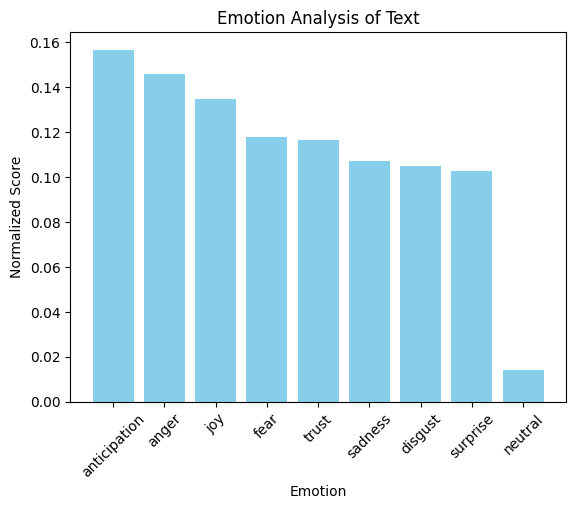

KeyboardInterrupt: 

In [1]:
import re
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt

# Emotion dictionary
emotion_map = {
    1: 'anger',
    2: 'anticipation',
    3: 'disgust',
    4: 'fear',
    5: 'joy',
    6: 'sadness',
    7: 'surprise',
    8: 'trust',
    0: 'neutral'
}

# Reading combined data
data = []

# Combined file
combined_file = "combined_data.tsv"  # Specify the path to the combined file
with open(combined_file, 'r', encoding='utf-8') as file:
    data = file.readlines()

# Dictionary for counting emotions per word
word_emotion_counts = defaultdict(Counter)

# Extended list of stop words
stop_words = set([
    'and', 'in', 'on', 'with', 'that', 'what', 'how', 'from', 'by', 'not', 'about', 'to', 'for', 'this', 'but', 'or',
    'the', 'a', 'of', 'is', 'it', 'was', 'i', 'you', 'as', 'be', 'are', 'an', 'they', 'we', 'all', 'can', 'has', 'there'
])

# Processing lines
for i, line in enumerate(data):
    # Skip lines with incorrect format
    if '\t' not in line or len(line.strip().split('\t')) != 2:
        continue  # Just skip the line

    try:
        sentence, labels = line.strip().split('\t')
        # Convert labels to emotions
        emotions = [emotion_map[int(label)] for label in labels.split(',')]
    except (ValueError, KeyError):
        continue  # Skip lines with conversion errors

    # Split the sentence into words
    words = re.findall(r'\w+', sentence.lower())
    words = [word for word in words if word not in stop_words]  # Remove stop words

    # Update emotion counts for each word
    for word in words:
        for emotion in emotions:
            word_emotion_counts[word][emotion] += 1

# Convert results into a DataFrame for further analysis
word_emotion_df = pd.DataFrame.from_dict(word_emotion_counts, orient='index').fillna(0)

# Ensure all emotions from emotion_map are present
for emotion in emotion_map.values():
    if emotion not in word_emotion_df.columns:
        word_emotion_df[emotion] = 0

# Function for analyzing text and considering n-grams
def analyze_text_with_ngrams(text, word_emotion_df, n=2):
    words = re.findall(r'\w+', text.lower())
    words = [word for word in words if word not in stop_words]  # Remove stop words
    ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    emotion_scores = Counter()
    influencing_ngrams = defaultdict(Counter)

    # Count emotions for each word and n-gram in the text
    for word in words + ngrams:
        if word in word_emotion_df.index:
            scores = word_emotion_df.loc[word].to_dict()
            emotion_scores.update(scores)
            for emotion, score in scores.items():
                influencing_ngrams[word][emotion] += score

    return emotion_scores, influencing_ngrams

# Input text for analysis
print("\nEnter text for analysis:")
new_text = input("> ").strip()

# Analyze text
emotion_scores, influencing_ngrams = analyze_text_with_ngrams(new_text, word_emotion_df, n=2)

# If the text contains no known words
if not emotion_scores:
    print("Could not determine emotions for the entered text. Try a different text.")
else:
    # Convert results into a DataFrame
    emotion_results = pd.DataFrame(emotion_scores.items(), columns=['Emotion', 'Score'])
    emotion_results['Normalized_Score'] = emotion_results['Score'] / emotion_results['Score'].sum()
    emotion_results = emotion_results.sort_values(by='Normalized_Score', ascending=False)

    # Display top-3 emotions
    top_emotions = emotion_results.head(3)
    print("\nTop-3 predominant emotions in the text:")
    for _, row in top_emotions.iterrows():
        print(f"- {row['Emotion'].capitalize()}: {row['Normalized_Score']:.2%}")

    # Plotting graph
    plt.bar(emotion_results['Emotion'], emotion_results['Normalized_Score'], color='skyblue')
    plt.title('Emotion Analysis of Text')
    plt.xlabel('Emotion')
    plt.ylabel('Normalized Score')
    plt.xticks(rotation=45)
    plt.show()

    # Display key words and n-grams for top-3 emotions
    print("\nKey words and n-grams influencing the top-3 emotions:")
    top_emotion_list = top_emotions['Emotion'].tolist()
    for emotion in top_emotion_list:
        print(f"\nEmotion: {emotion.capitalize()}")
        relevant_ngrams = [(ngram, scores[emotion]) for ngram, scores in influencing_ngrams.items() if scores[emotion] > 0 and ngram not in stop_words]
        relevant_ngrams = sorted(relevant_ngrams, key=lambda x: x[1], reverse=True)[:5]
        for ngram, score in relevant_ngrams:
            print(f"- {ngram}: {score}")
